# Brain MRI Segmentation - Kaggle

In [1]:
## Packages

import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

2023-09-19 15:26:46.830478: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [43]:
from utils import *
from models import *

In [2]:
# Size of images
im_width = 256
im_height = 256

In [42]:
EPOCHS = 100
BATCH_SIZE = 32
learning_rate = 1e-4
smooth = 1e-5

### Load images and masks

In [7]:
image_filenames_train = []

# local
mask_files = glob('./archive/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    image_filenames_train.append(i.replace('_mask', ''))

for i in range(10):
    print(str(image_filenames_train[i]))
print(len(image_filenames_train))

./archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_8.tif
./archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_9.tif
./archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_2.tif
./archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_3.tif
./archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_20.tif
./archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_15.tif
./archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_14.tif
./archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_18.tif
./archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_19.tif
./archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_12.tif
3929


In [30]:
def plot_from_img_path(rows, columns, list_img_path, list_mask_path):
    """ This function plots a grid of images and their corresponding masks from given lists of image and mask paths.
    It uses matplotlib for plotting and OpenCV for reading and processing the images.

    Parameters:
    -----------
    rows : int
        The number of rows in the plot grid.

    columns : int
        The number of columns in the plot grid.

    list_img_path : list of str
        A list of paths to the image files to be plotted.

    list_mask_path : list of str
        A list of paths to the mask files to be plotted.

    Returns:
    --------
    None

    Notes:
    ------
    The images are displayed in RGB format, and the masks are overlaid on the images
    with a transparency of 0.4. """
    fig = plt.figure(figsize = (12, 12))
    for i in range(1, rows * columns + 1):
        fig.add_subplot(rows, columns, i)
        img_path = list_img_path[i]
        mask_path = list_mask_path[i]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path)
        plt.imshow(image)
        plt.imshow(mask, alpha = 0.64)
        plt.grid(False)
    plt.show()

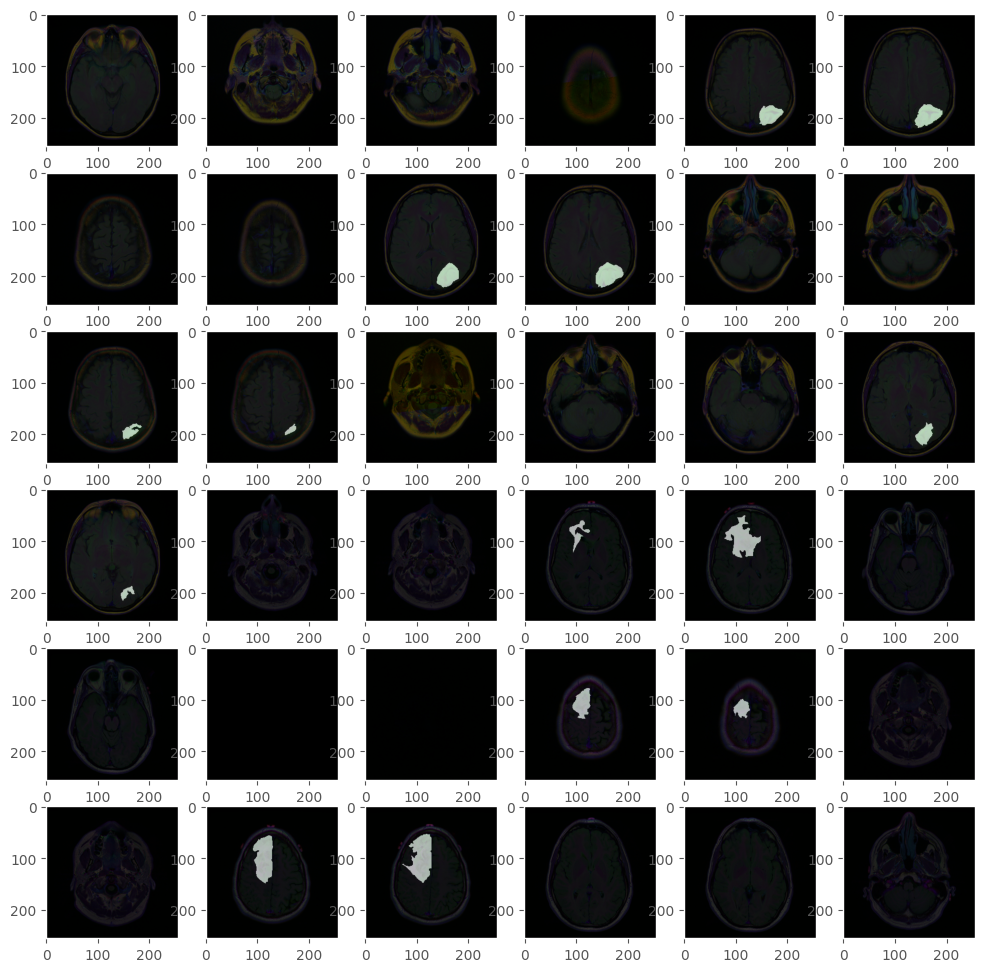

In [34]:
plot_from_img_path(6, 6 , image_filenames_train, mask_files )

In [39]:
df.head()

,image_filenames_train,mask
0,./archive/lgg-mri-segmentation/kaggle_3m/TCGA_...,./archive/lgg-mri-segmentation/kaggle_3m/TCGA_...
1,./archive/lgg-mri-segmentation/kaggle_3m/TCGA_...,./archive/lgg-mri-segmentation/kaggle_3m/TCGA_...
2,./archive/lgg-mri-segmentation/kaggle_3m/TCGA_...,./archive/lgg-mri-segmentation/kaggle_3m/TCGA_...
3,./archive/lgg-mri-segmentation/kaggle_3m/TCGA_...,./archive/lgg-mri-segmentation/kaggle_3m/TCGA_...
4,./archive/lgg-mri-segmentation/kaggle_3m/TCGA_...,./archive/lgg-mri-segmentation/kaggle_3m/TCGA_...


In [18]:
df = pd.DataFrame(data = {'image_filenames_train': image_filenames_train, 'mask': mask_files})

df_train, df_test = train_test_split(df, test_size = 0.1)

# Further split this val and train
df_train, df_val = train_test_split(df_train, test_size = 0.2)

print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

(2828, 2)
(393, 2)
(708, 2)


In [40]:
# Referring Code From: https://github.com/zhixuhao/unet/blob/master/data.py
seed = 42

def train_generator(data_frame, 
                    batch_size, 
                    augmentation_dict,
                    image_color_mode = "rgb",
                    mask_color_mode = "grayscale",
                    image_save_prefix = "image", 
                    mask_save_prefix = "mask",
                    save_to_dir = 42,
                    target_size = (256, 256),
                    seed = seed
                    ):
    """
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    """
    image_datagen = ImageDataGenerator(**augmentation_dict)
    mask_datagen = ImageDataGenerator(**augmentation_dict)

    image_generator = image_datagen.flow_from_dataframe(data_frame,
                                                        x_col = "image_filenames_train",
                                                        class_mode = None,
                                                        color_mode = image_color_mode,
                                                        target_size = target_size,
                                                        batch_size = batch_size,
                                                        save_to_dir = save_to_dir,
                                                        save_prefix = image_save_prefix,
                                                        seed = seed
                                                        )

    mask_generator = mask_datagen.flow_from_dataframe(data_frame,
                                                      x_col = "mask",
                                                      class_mode = None,
                                                      color_mode = mask_color_mode,
                                                      target_size = target_size,
                                                      batch_size = batch_size,
                                                      save_to_dir = save_to_dir,
                                                      save_prefix = mask_save_prefix,
                                                      seed = seed
                                                      )

    train_gen = zip(image_generator, mask_generator)
    
    # normalize & return tuple (img, mask)
    for (img, mask) in train_gen:
        
        img = img / 255.
        mask = mask / 255.
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
        
        yield (img, mask)

In [45]:
model = unet()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 256, 256, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 activation_18 (Activation)  (None, 256, 256, 64)         0         ['conv2d_19[0][0]']           
                                                                                                  
 conv2d_20 (Conv2D)          (None, 256, 256, 64)         36928     ['activation_18[0][0]']       
                                                                                            